# 4.10 Instacart Profiling Part 1

# Table of Contents

1. [Importing the data set (Q1)](#importing)
2. [Security checks (Q2)](#security)
3. [Regional division (Q3)](#regional)
4. [Regional data markup](#regional-markup)
5. [Spending habits between the different U.S. regions](#spending-habits)
6. [Excluding Low activity clients (Q4)](#low-activity)
7. [Profiling customers (Q5)](#profiling)
   1. [Discovery of clusters of customer demographic and consumption habits profiles](#discovery-clusters)
   2. [Clustering by income](#clustering-income)
   3. [Clustering by family status and number of dependants](#clustering-family)
   4. [Clustering by loyalty](#clustering-loyalty)
   5. [Clustering by activity](#clustering-activity)
   6. [Clustering by order frequency](#clustering-frequency)
   7. [Clustering by region](#clustering-region)
   8. [Clustering by spendings](#clustering-spendings)
   9. [Formalizing rules for profiles](#formalizing-rules)
8. [Profiles scoring](#scoring)
   1. [Scoring profiles by overall revenue from orders (Q7)](#scoring-revenue)
   2. [Expenditure: Max, mean, and min variables on a customer-profile level for expenditure (Q7)](#expenditure)
   3. [Usage frequency: Max, mean, and min variables on a customer-profile level for Usage frequency (Q7)](#usage-frequency)
   4. [Comparing customer profiles with regions and product's departments. (Q8)](#comparing-profiles)
   5. [Comparing customer profiles popular product's departments. (Q8)](#comparing-departments)

### Importing the data set (Q1) <a class="anchor" id="importing"></a>

In [3]:
# Import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [5]:
# Reletive path
path = '../'

In [ ]:
# Loading dataframe ords_prods_cust_merge.pkl
ords_prods_merge = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'ords_prods_cust_merge.pkl'))

### Security checks (Q2) <a class="anchor" id="security"></a>

In [23]:
# No PII data was found
ords_prods_merge.columns

Index(['Unnamed: 0_x', 'order_id', 'user_id', 'eval_set', 'order_number',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'product_id', 'add_to_cart_order', 'reordered', 'Unnamed: 0_y',
       'product_name', 'aisle_id', 'department_id', 'prices',
       'price_range_loc', 'busiest_days', 'busiest_period_of_day', 'max_order',
       'loyalty_flag', 'user_mean_price', 'spending_flag',
       'median_prior_orders', 'order_frequency_flag', 'gender', 'state', 'age',
       'date_joined', 'number_dependants', 'family_status', 'income', '_merge',
       'region', 'activity_flag'],
      dtype='object')

Data is already abfuscated (Q2)

### Regional division (Q3) <a class="anchor" id="regional"></a>

#### Regional data markup <a class="anchor" id="regional-markup"></a>

In [5]:
# Defining regoins lists
northeast_region = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 
                    'New York', 'Pennsylvania', 'New Jersey']

midwest_region = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 
                  'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']

south_region = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 
                'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 
                'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 
                'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']

west_region = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 
               'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

In [7]:
# Creating new column Region
ords_prods_merge.loc[ords_prods_merge['state'].isin(northeast_region), 'region'] = 'Northeast'
ords_prods_merge.loc[ords_prods_merge['state'].isin(midwest_region), 'region'] = 'Midwest'
ords_prods_merge.loc[ords_prods_merge['state'].isin(south_region), 'region'] = 'South'
ords_prods_merge.loc[ords_prods_merge['state'].isin(west_region), 'region'] = 'West'

In [8]:
#Check region values
ords_prods_merge['region'].value_counts(dropna = False)

South        10870719
West          8353182
Midwest       7652535
Northeast     5764832
Name: region, dtype: int64

No data with NaN regions founds.

#### Spending habits between the different U.S. regions. <a class="anchor" id="spending-habits"></a>

In [10]:
# Crosstab spending habits across regions
crosstab_spending_habits = pd.crosstab (ords_prods_merge['spending_flag'] , ords_prods_merge['region'], dropna = False)
crosstab_spending_habits

region,Midwest,Northeast,South,West
spending_flag,,,,
High spender,157347,109159,211695,161834
Low spender,7495188,5655673,10659024,8191348


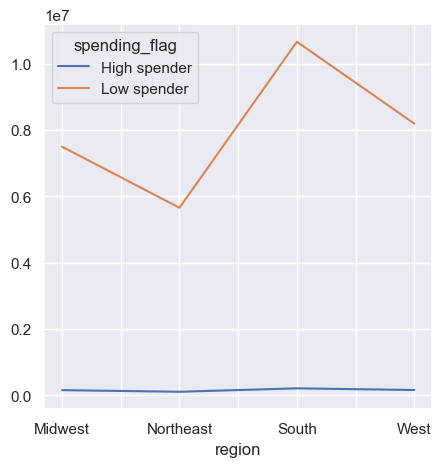

In [464]:
# Ploting the line chart of spendings Crosstab
line_plot_total_spendings = crosstab_spending_habits.T.plot.line()

In [468]:
line_plot_total_spendings.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_plot_total_spendings.png'))

In [13]:
# Normalized crosstab spending habits across regions
crosstab_spending_habits_normalyzed = pd.crosstab (ords_prods_merge['spending_flag'] , ords_prods_merge['region'], dropna = False, normalize = 'index')
crosstab_spending_habits_normalyzed

region,Midwest,Northeast,South,West
spending_flag,,,,
High spender,0.245841,0.170552,0.330755,0.252852
Low spender,0.234216,0.176733,0.333082,0.255970


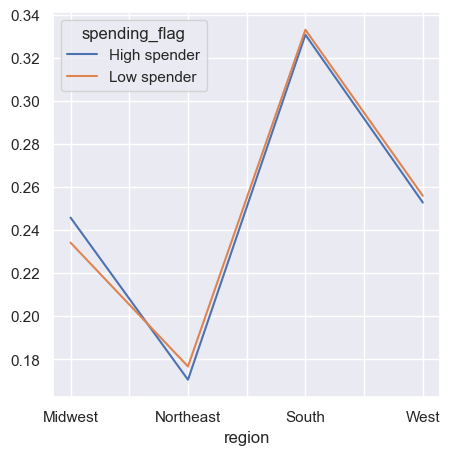

In [466]:
# Ploting the line chart of normalyzed spendings Crosstab
line_plot_total_spendings_normalyzed = crosstab_spending_habits_normalyzed.T.plot.line()

In [469]:
line_plot_total_spendings_normalyzed.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_plot_total_spendings_normalyzed.png'))

Observations: 

The total number of units sold varies by region.

There is no indication of a significant change in the share of high and low-spending customers between regions.

In [21]:
# Saving linechart 
line_plot_total_spendings_normalyzed.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_plot_total_spendings_normalyzed.png'))

## Excluding Low activity clients (Q4) <a class="anchor" id="low-activity"></a>

In [22]:
# Creating conditions for 'activity_flag' based on max number of orders.
ords_prods_merge.loc[ords_prods_merge['max_order'] < 5, 'activity_flag'] = 'low activity'
ords_prods_merge.loc[ords_prods_merge['max_order'] >= 5, 'activity_flag'] = 'high activity'
ords_prods_merge['activity_flag'].value_counts(dropna = False)

high activity    31929979
low activity       711289
Name: activity_flag, dtype: int64

In [523]:
# Create a new dataframe to store the high-activity customers
df_high_activity = ords_prods_merge.loc[ords_prods_merge['activity_flag']=='high activity']

In [524]:
# Export high activity dataframe
df_high_activity.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'high_activity_customers.pkl'))

# Profiling customers (Q5 <a class="anchor" id="profiling"></a>

This part will search for clusters of customers based on known information about demographics: such as age, gender, income, marital status, number of children and consumer habits: activity, fidelity, total number of orders, total amount of orders, the average time and day in which this cluster of customers makes an order and others.

First an automatic clustering was done using the kmeans algorithm, in order to identify the 12 main clusters. After that, a visual analysis of each of the found clusters was performed, in terms of demographics and most of the consumer habits of the customers in the cluster. 

As a result of this analysis, the parameters that define each of the clusters were found to help place each new customer into one or the other cluster of profiles, for subsequent analysis or prediction of consumer behavior.
As a result, a scoring of the found clusters was done, regarding the consumption patterns of different products and expected revenues, in order to evaluate the marketing potential of each profile. 

### 1. Discovery of clusters of customer demographic and consumption habits profiles <a class="anchor" id="discovery-clusters"></a>

In [138]:
# Removeing any columns that are not relevant for profile clustering
user_cluster_df = ords_prods_merge.drop(['Unnamed: 0_x','Unnamed: 0_y', 'product_name', 'order_id', 'department_id','price_range_loc', 'busiest_days', 'busiest_period_of_day', 'aisle_id', 'eval_set' , 'order_number', 'median_prior_orders',
                                 'product_id', 'add_to_cart_order', '_merge'], axis=1)

In [139]:
# Aggregating customers info
user_cluster_df = user_cluster_df.groupby('user_id').agg({
    'age': 'mean', 
    'income': 'mean', 
    'gender': lambda x: x.mode()[0], 
    'number_dependants': 'mean', 
    'family_status': lambda x: x.mode()[0],
    'loyalty_flag': lambda x: x.mode()[0], 
    'spending_flag': lambda x: x.mode()[0],
    'activity_flag': lambda x: x.mode()[0],
    'order_frequency_flag': lambda x: x.mode()[0],
    'max_order': 'mean',
    'prices': ['mean', 'min', 'max', 'sum'],
    'user_mean_price': 'mean',
    'order_hour_of_day': 'mean', 
    'orders_day_of_week': 'mean', 
    'days_since_prior_order': 'mean',
    'reordered': 'count',
    'region': lambda x: x.mode()[0],
    'date_joined': lambda x: x.mode()[0]   
})

In [140]:
# Flattenning the column names of the user_df dataframe:
user_cluster_df.columns = ['_'.join(col).strip() if 'prices' in col[0] else col[0] for col in user_cluster_df.columns.values]

In [141]:
user_cluster_df.columns

Index(['age', 'income', 'gender', 'number_dependants', 'family_status',
       'loyalty_flag', 'spending_flag', 'activity_flag',
       'order_frequency_flag', 'max_order', 'prices_mean', 'prices_min',
       'prices_max', 'prices_sum', 'user_mean_price', 'order_hour_of_day',
       'orders_day_of_week', 'days_since_prior_order', 'reordered', 'region',
       'date_joined'],
      dtype='object')

In [ ]:
user_cluster_df.head(20)

In [142]:
# Converting categorical variables to numerical variables using one-hot encoding.
user_cluster_df_dumm = pd.get_dummies(user_cluster_df.drop('date_joined', axis=1), columns=[
    'age',
    'gender',
    'number_dependants', 
    'family_status', 
    'loyalty_flag', 
    'spending_flag', 
    'activity_flag',
    'order_frequency_flag',
    'region'
])

In [143]:
# Scaleing the numerical variables using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_user_cluster_df = scaler.fit_transform(user_cluster_df_dumm)

In [154]:
# Using KMeans clustering algorithm to cluster the customers
from sklearn.cluster import KMeans
# Set random seed for reproducibility
np.random.seed(42)
kmeans = KMeans(n_clusters=12, random_state=42).fit(scaled_user_cluster_df)

In [155]:
# Adding the cluster labels to the original dataframe
user_cluster_df['cluster'] = kmeans.labels_

In [246]:
# Exporting the result of clustering to save clusters numbers between sessions.
# Even so the seed number for a kmean algorithm is preserved, the customers data could be cheged, 
# whech could lead to changing of clusters numbers.
# To preserve results of previous reserch dataframe with marcked clusters should be saves.
user_cluster_df.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'customers_clusters_test.pkl'))

In [ ]:
# Loading a dataframe with restore clusters numbers
user_cluster_df = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'customers_clusters.pkl'))

In [ ]:
# Grouping the data by cluster and calculateing the mean for each column
cluster_means = user_cluster_df.groupby('cluster').mean()

# Printing the mean values for each cluster
print(cluster_means)

#### Number of customers in cluster

Text(0.5, 1.0, 'Number of customers in each cluster')

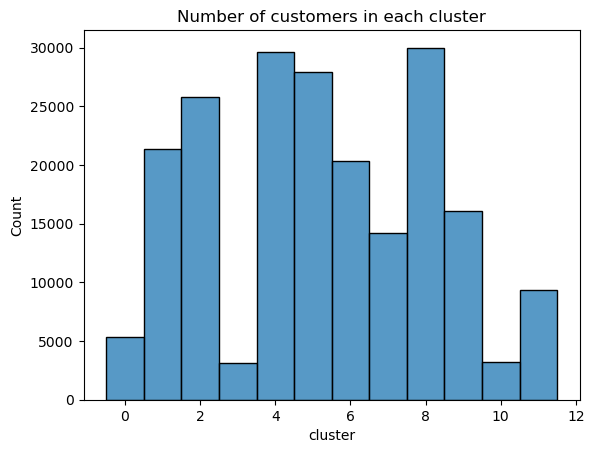

In [171]:
# Plotting the number of customers in each cluster
cluesters_customers_count = sns.histplot(data=user_cluster_df, x='cluster', discrete=True)
plt.title('Number of customers in each cluster')

In [504]:
cluesters_customers_count.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'cluesters_customers_count.png'))

In [332]:
# Adding number of customers in cluster to profile comparision
Profile_comparision['customers_count']= user_cluster_df.groupby('cluster').count()['age']

### 2. Clustering by income <a class="anchor" id="clustering-income"></a>

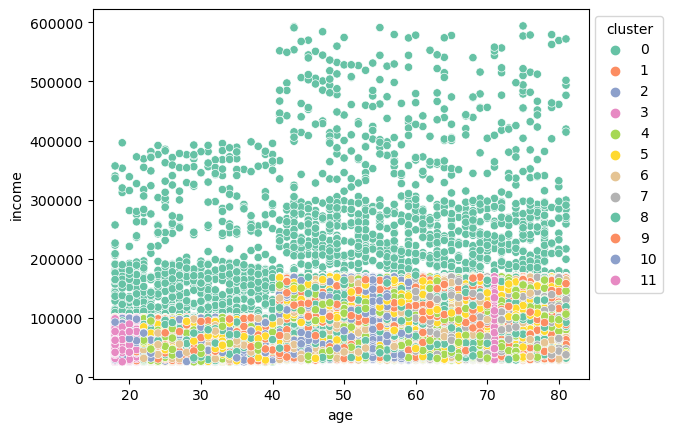

In [172]:
scatterplot_income_age = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='cluster', palette="Set2")
sns.move_legend(scatterplot_income_age, "upper left", bbox_to_anchor=(1, 1))

In [471]:
scatterplot_income_age.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age.png'))

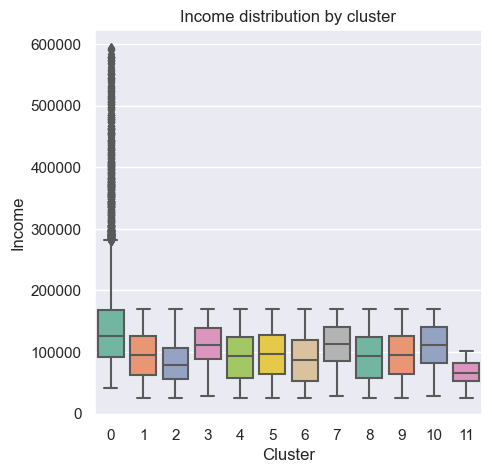

In [474]:
# Createing a box plot for the distribution of income for each cluster
income_distribution_boxplot = sns.boxplot(x='cluster', y='income', data=user_cluster_df, palette="Set2")
plt.title('Income distribution by cluster')
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.show()

In [475]:
income_distribution_boxplot.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'income_distribution_boxplot.png'))

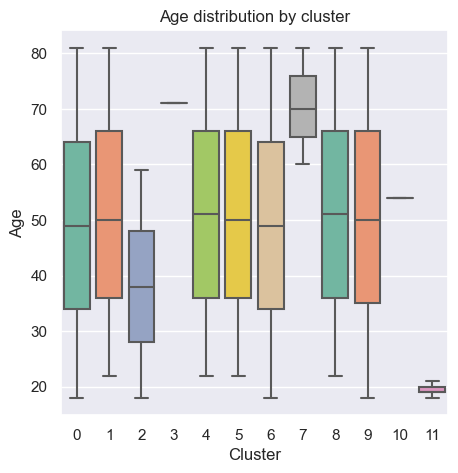

In [473]:
# Createing a box plot for the distribution of age for each cluster
age_distribution_boxplot = sns.boxplot(x='cluster', y='age', data=user_cluster_df, palette="Set2")
plt.title('Age distribution by cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

In [476]:
age_distribution_boxplot.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'age_distribution_boxplot.png'))

In [225]:
# Observations of grouping by age and income: 
age_and_income = {
    0: '18-40 years with income 100k - 200k and > 40 years with income >200k',
    1: '22-40 years with income <100k and >40 years with income <200k',
    2: '18-60 but mostly from 30 to 50 years with mostly income <100K',
    3: '72 years with income > 100k - 200K',
    4: '22-40 years with income <100K and >40 with income <200k',
    5: '22-40 years with income <100K and >40 with income <200k',
    6: '18-40 years with income <100K and >40 with income <200k',
    7: '>60 years with income mostly 100K-200k',
    8: '22-40 years with income <100k and >40 with income <200k',
    9: '18-40 years with income <100k and >40 with income <200k',
    10: '54 years with income mostly 100K-200k',
    11: '18-22 years with income < 100k'
}
Profile_comparision = pd.DataFrame()
    
Profile_comparision['age_and_income'] = pd.Series(age_and_income)

### 3. Clustering by family status and number of dependants <a class="anchor" id="clustering-family"></a>

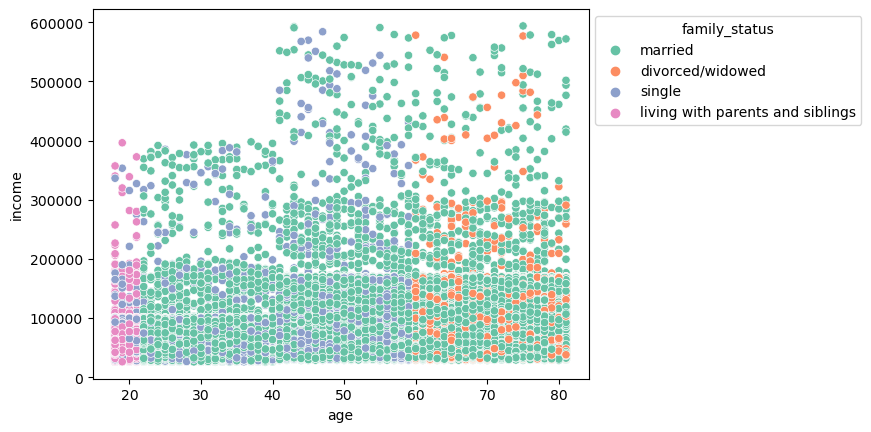

In [174]:
scatterplot_income_age_family_status = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='family_status', palette="Set2")
sns.move_legend(scatterplot_income_age_family_status, "upper left", bbox_to_anchor=(1, 1))

In [477]:
scatterplot_income_age_family_status.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_family_status.png'))

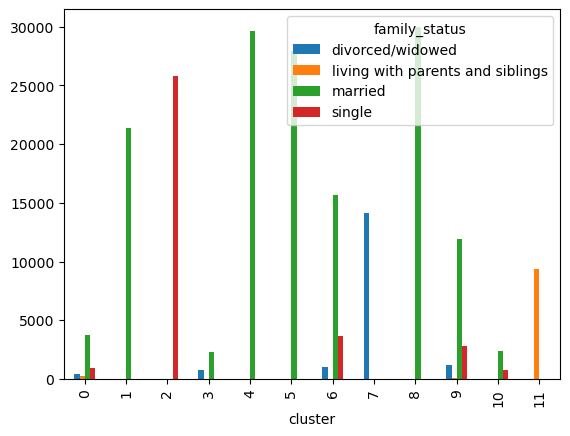

In [175]:
# Creating crosstub for clusters and famliy status.
crosstab_famliy_status_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['family_status'], dropna = False)
# Plotting 
bar_chart_famliy_status_cluster = crosstab_famliy_status_cluster.plot(kind='bar', stacked=False)

In [478]:
bar_chart_famliy_status_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_famliy_status_cluster.png'))

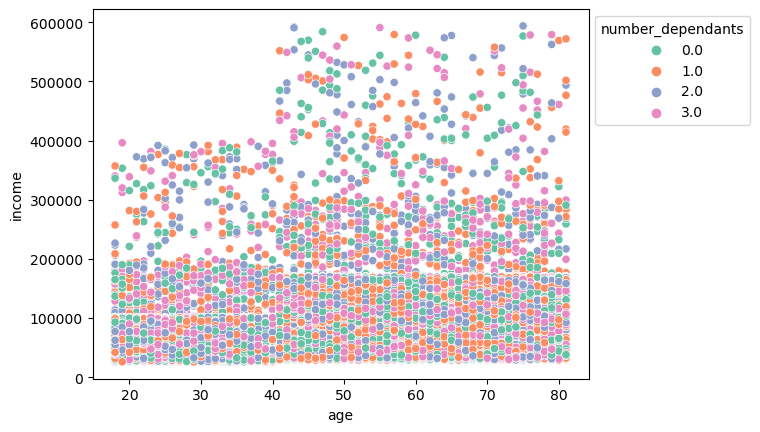

In [176]:
scatterplot_income_age_number_dependants = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='number_dependants', palette="Set2")
sns.move_legend(scatterplot_income_age_number_dependants, "upper left", bbox_to_anchor=(1, 1))

In [480]:
scatterplot_income_age_number_dependants.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_number_dependants.png'))


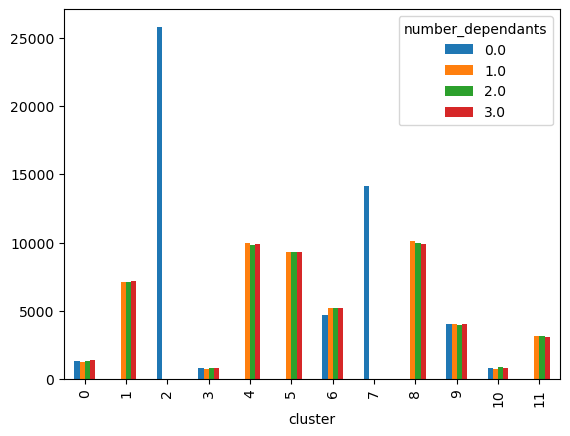

In [177]:
# Creating crosstub for clusters and number_dependants.
crosstab_number_dependants_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['number_dependants'], dropna = False)
# Plotting 
bar_chart_number_dependants_cluster = crosstab_number_dependants_cluster.plot(kind='bar', stacked=False)

In [481]:
bar_chart_number_dependants_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_number_dependants_cluster.png'))

In [226]:
# Observations of grouping by family status and number of dependants
family_status = {
    0: 'mostly married',
    1: 'maried and have at least 1 child',
    2: 'single and no children',
    3: 'maried or divorced',
    4: 'maried and have at least one child',
    5: 'maried and have at least one child',
    6: 'no distinctive features',
    7: 'divorced without children',
    8: 'maried and could have children and have at least one child',
    9: 'no distinctive features: could be maried or not and could have children or no',
    10: 'no distinctive features: could be maried or not and could have children or no',
    11: 'living with parants and siblings (numer of dependants surprisingly > 0)'
}
Profile_comparision['family_status'] = pd.Series(family_status)

### 4. Clustering by loyalty <a class="anchor" id="clustering-loyalty"></a>

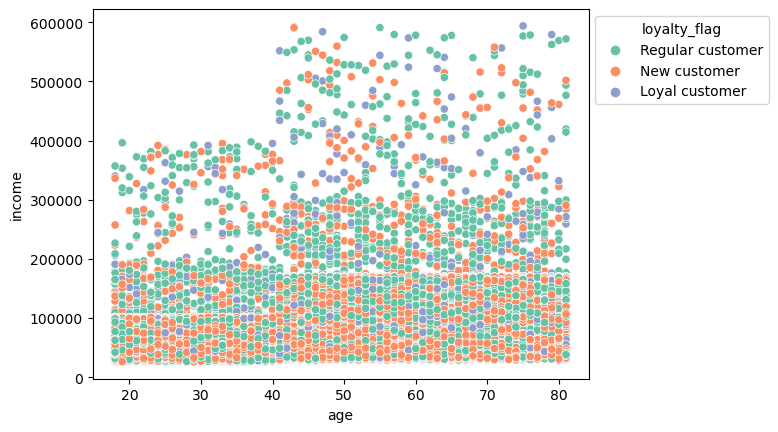

In [178]:
scatterplot_income_age_loyalty = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='loyalty_flag', palette="Set2")
sns.move_legend(scatterplot_income_age_loyalty, "upper left", bbox_to_anchor=(1, 1))

In [482]:
scatterplot_income_age_loyalty.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_loyalty.png'))

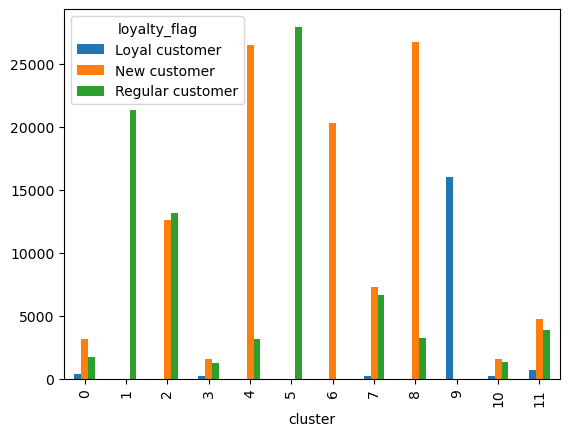

In [179]:
# Creating crosstub for clusters and loyalty flag.
crosstab_loyalty_flag_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['loyalty_flag'], dropna = False)
# Plotting 
bar_chart_loyalty_flag_cluster = crosstab_loyalty_flag_cluster.plot(kind='bar', stacked=False)

In [483]:
bar_chart_loyalty_flag_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_loyalty_flag_cluster.png'))

In [228]:
# Observations of grouping by loyalty
loyalty = {
    0: 'mostly new customers',
    1: 'regular customers',
    2: 'new or regular customers',
    3: 'no distinctive features',
    4: 'mostly new customers but could be regular',
    5: 'regular customers',
    6: 'new customers',
    7: 'mostly new or regular customers',
    8: 'mostly new customers, but could be regular',
    9: 'loyal customers',
    10: 'no distinctive features',
    11: 'no distinctive features'
}
Profile_comparision['loyalty'] = pd.Series(loyalty)

### 5. Clustering by activity. <a class="anchor" id="clustering-activity"></a>

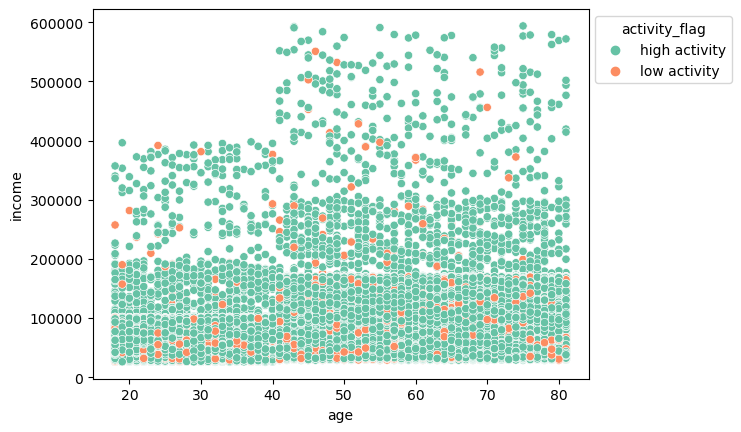

In [180]:
scatterplot_income_age_activity_flag = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='activity_flag', palette="Set2")
sns.move_legend(scatterplot_income_age_activity_flag, "upper left", bbox_to_anchor=(1, 1))

In [484]:
scatterplot_income_age_activity_flag.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_activity_flag.png'))

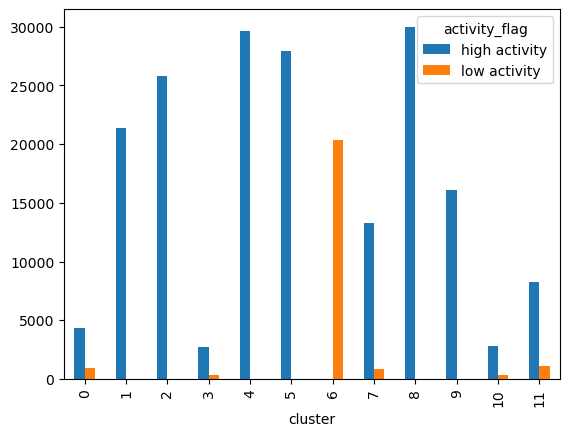

In [182]:
# Creating crosstub for clusters and activity.
crosstab_activity_flag_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['activity_flag'], dropna = False)
# Plotting 
bar_chart_activity_flag_cluster = crosstab_activity_flag_cluster.plot(kind='bar', stacked=False)

In [485]:
bar_chart_activity_flag_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_activity_flag_cluster.png'))

In [229]:
# Observations of grouping by activity
activity = {
    0: 'mostly high active',
    1: 'high active',
    2: 'high active',
    3: 'mostly high active',
    4: 'high active',
    5: 'high active',
    6: 'low active',
    7: 'mostly high active',
    8: 'high active',
    9: 'high active',
    10: 'mostly high active',
    11: 'mostly high active'
}
Profile_comparision['activity'] = pd.Series(activity)

### 6. Clustering by order frequency. <a class="anchor" id="clustering-frequency"></a>

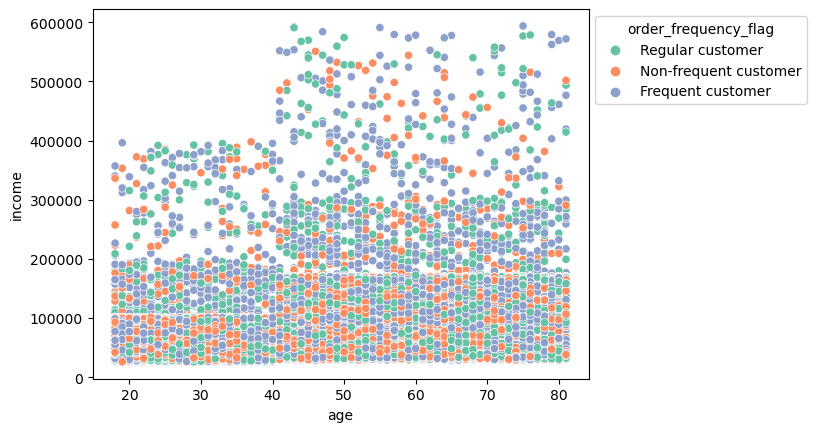

In [183]:
scatterplot_income_age_order_frequency_flag = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='order_frequency_flag', palette="Set2")
sns.move_legend(scatterplot_income_age_order_frequency_flag, "upper left", bbox_to_anchor=(1, 1))

In [486]:
scatterplot_income_age_order_frequency_flag.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_order_frequency_flag.png'))

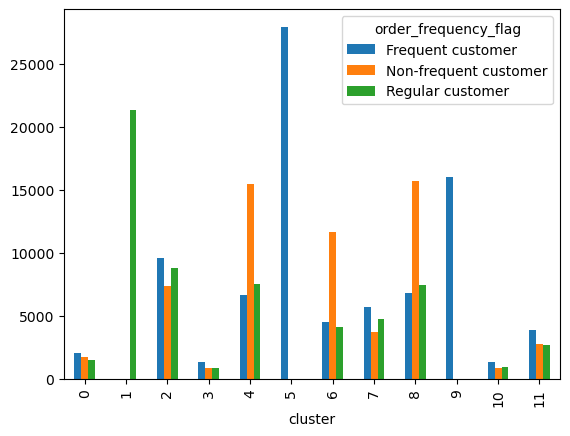

In [231]:
# Creating crosstub for clusters and activity.
crosstab_activity_flag_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['order_frequency_flag'], dropna = False)
# Plotting 
bar_chart_activity_flag_cluster = crosstab_activity_flag_cluster.plot(kind='bar', stacked=False)
Non-frequent customer

In [487]:
bar_chart_activity_flag_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_activity_flag_cluster.png'))

In [232]:
# Observations of grouping by order frequency
order_frequency = {
    0: 'no distinctive features',
    1: 'regular',
    2: 'no distinctive features',
    3: 'no distinctive features',
    4: 'more non-frequet',
    5: 'frequent',
    6: 'more non-frequet',
    7: 'no distinctive features',
    8: 'more non-frequet',
    9: 'frequent',
    10: 'no distinctive features',
    11: 'no distinctive features'
}
Profile_comparision['order_frequency'] = pd.Series(order_frequency)

### 7. Clustering by region <a class="anchor" id="clustering-region"></a>

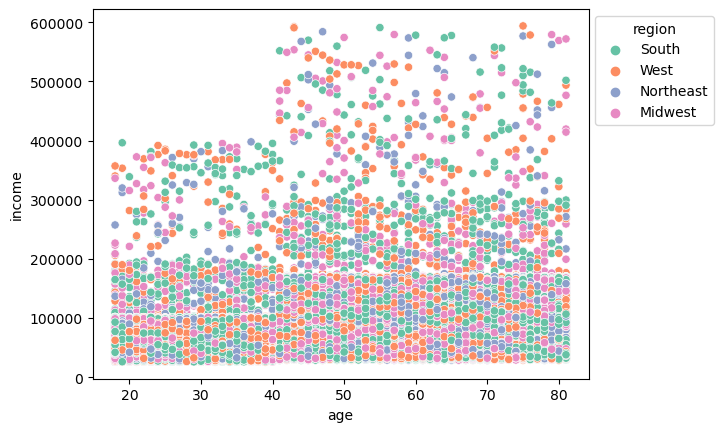

In [241]:
scatterplot_income_age_region = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='region', palette="Set2")
sns.move_legend(scatterplot_income_age_region, "upper left", bbox_to_anchor=(1, 1))

In [488]:
scatterplot_income_age_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_region.png'))

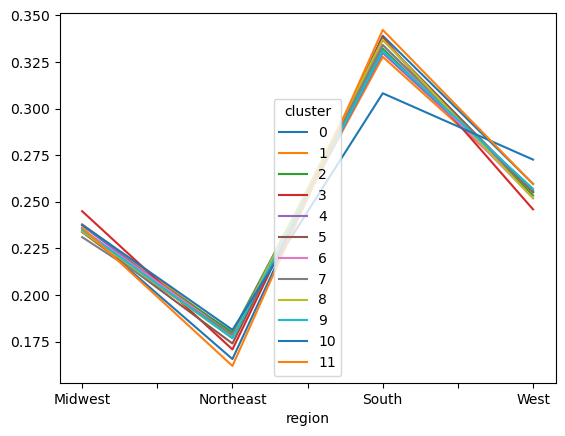

In [242]:
# Creating crosstub for clusters and region.
crosstab_region_cluster = pd.crosstab( user_cluster_df['cluster'], user_cluster_df['region'],  dropna = False, normalize = 'index')
# Plotting 
bar_chart_region_cluster = crosstab_region_cluster.T.plot.line()

In [489]:
bar_chart_region_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_region_cluster.png'))

Obcervation: No distinctive features found in regionality usfull for profiling

### 8. Clustering by spendings <a class="anchor" id="clustering-spendings"></a>

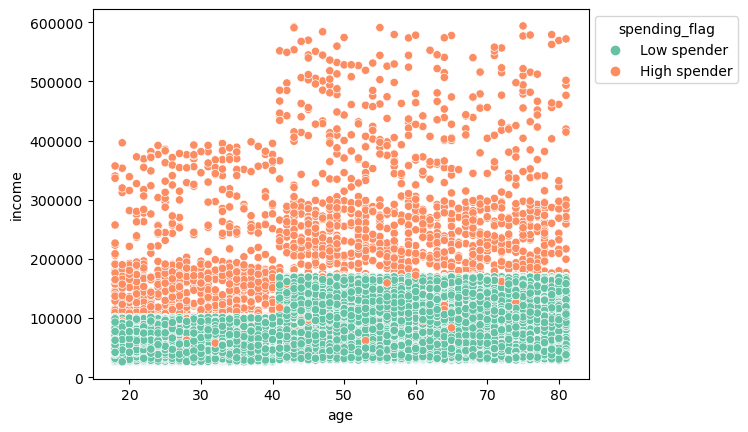

In [243]:
scatterplot_income_age_spending_flag = sns.scatterplot(x = 'age', y = 'income', data = user_cluster_df, hue='spending_flag', palette="Set2")
sns.move_legend(scatterplot_income_age_spending_flag, "upper left", bbox_to_anchor=(1, 1))

In [490]:
scatterplot_income_age_spending_flag.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatterplot_income_age_spending_flag.png'))

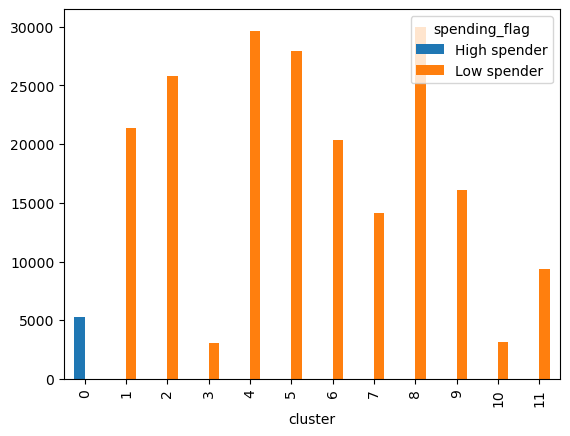

In [244]:
# Creating crosstub for clusters and spendings.
crosstab_spendings_cluster = pd.crosstab(user_cluster_df['cluster'], user_cluster_df['spending_flag'], dropna = False)
# Plotting 
bar_chart_spendings_cluster = crosstab_spendings_cluster.plot(kind='bar', stacked=False)

In [491]:
bar_chart_spendings_cluster.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_chart_spendings_cluster.png'))

In [245]:
# Observations of grouping by activity
spending = {
    0: 'high spender',
    1: 'low spender',
    2: 'low spender',
    3: 'low spender',
    4: 'low spender',
    5: 'low spender',
    6: 'low spender',
    7: 'low spender',
    8: 'low spender',
    9: 'low spender',
    10: 'low spender',
    11: 'low spender'
}
Profile_comparision['spending'] = pd.Series(spending)

### 9. Formalizing rules for profiles <a class="anchor" id="formalizing-rules"></a>

In [333]:
# Comparing findings
Profile_comparision

,age_and_income,family_status,loyalty,activity,order_frequency,spending,customers_count
0,18-40 years with income 100k - 200k and > 40 y...,mostly married,mostly new customers,mostly high active,no distinctive features,high spender,5311
1,22-40 years with income <100k and >40 years wi...,maried and have at least 1 child,regular customers,high active,regular,low spender,21354
2,18-60 but mostly from 30 to 50 years with most...,single and no children,new or regular customers,high active,no distinctive features,low spender,25795
3,72 years with income > 100k - 200K,maried or divorced,no distinctive features,mostly high active,no distinctive features,low spender,3102
4,22-40 years with income <100K and >40 with inc...,maried and have at least one child,mostly new customers but could be regular,high active,more non-frequet,low spender,29650
5,22-40 years with income <100K and >40 with inc...,maried and have at least one child,regular customers,high active,frequent,low spender,27949
6,18-40 years with income <100K and >40 with inc...,mostly maried but could be single or divorced ...,new customers,low active,more non-frequet,low spender,20315
7,>60 years with income mostly 100K-200k,divorced without children,mostly new or regular customers,mostly high active,no distinctive features,low spender,14172
8,22-40 years with income <100k and >40 with inc...,maried and could have children and have at lea...,"mostly new customers, but could be regular",high active,more non-frequet,low spender,29982
9,18-40 years with income <100k and >40 with inc...,no distinctive features: could be maried or no...,loyal customers,high active,frequent,low spender,16064


In [293]:
# Profile rule for Young High spender (cluster 0)
ords_prods_merge.loc[(ords_prods_merge['spending_flag'].isin(['High spender']))&(ords_prods_merge['age']<40)
                     , 'profile'] = 'Young high spender'

In [294]:
# Profile rule for Mature High spender (cluster 0)
ords_prods_merge.loc[(ords_prods_merge['spending_flag'].isin(['High spender']))&(ords_prods_merge['age']>=40)
                     , 'profile'] = 'Mature high spender'

In [295]:
# Profile rule for Regular customers with children (cluster 1)
ords_prods_merge.loc[
    (ords_prods_merge['family_status'].isin(['married'])) 
    &(ords_prods_merge['order_frequency_flag'].isin(['Regular customer'])) 
    &(ords_prods_merge['number_dependants']>0) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Regular customers with children'

In [297]:
# Profile rule for Single adults(cluster 2)
ords_prods_merge.loc[
    (ords_prods_merge['family_status'].isin(['single'])) 
    &(ords_prods_merge['number_dependants']==0)
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Single adult'

In [260]:
# Not taking into account cluster 3 because of a low number of customers

In [299]:
# Profile rule for New customers with children (cluster 4)
ords_prods_merge.loc[
    (ords_prods_merge['loyalty_flag'].isin(['New customer'])) 
    &(ords_prods_merge['number_dependants']>0) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'New customers with children'

In [301]:
# Profile rule for Frequent customers with children (cluster 5)
ords_prods_merge.loc[
    (ords_prods_merge['family_status'].isin(['married']))
    &(ords_prods_merge['order_frequency_flag'].isin(['Frequent customer'])) 
    &(ords_prods_merge['number_dependants']>0) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Frequent customers with children'

In [303]:
# Profile rule for Low activity customers (cluster 6)
ords_prods_merge.loc[
    (ords_prods_merge['activity_flag'].isin(['low activity'])) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])) , 
    'profile'] = 'Low activity customers'

In [305]:
# Profile rule for divorced or widowed (cluster 7)
ords_prods_merge.loc[
    (ords_prods_merge['family_status'].isin(['divorced/widowed'])) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Divorced or widowed'

In [306]:
# Not taking into account cluster 8 because of a low difference from the cluster 4

In [307]:
# Profile rule for Loyal customers(cluster 9)
ords_prods_merge.loc[
    (ords_prods_merge['loyalty_flag'].isin(['Loyal customer'])) 
    & (ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Loyal customer'

In [269]:
# Not taking into account cluster 10 because of a low number of customers

In [308]:
# Profile rule for Living with parents and siblings(cluster 11)
ords_prods_merge.loc[
    (ords_prods_merge['family_status'].isin(['living with parents and siblings'])) 
    &(ords_prods_merge['spending_flag'].isin(['Low spender'])), 
    'profile'] = 'Frequent customers with children'

In [291]:
# To clear the profile column
# ords_prods_merge['profile'] = ''

In [340]:
profile_customers_count = ords_prods_merge['profile'].value_counts(dropna = False)
profile_customers_count

Loyal customer                      9958723
Frequent customers with children    8990913
Regular customers with children     3901005
Single adult                        3411250
New customers with children         2487790
Divorced or widowed                 1838153
                                     811056
Low activity customers               602343
Mature high spender                  426889
Young high spender                   213146
Name: profile, dtype: int64

In [526]:
ords_prods_merge.shape

(32641268, 37)

In [527]:
# Creating a dataframe to store the high-activity customers
df_profiled_high_activity = ords_prods_merge.loc[ords_prods_merge['activity_flag']=='high activity']

In [528]:
df_profiled_high_activity.shape

(31929979, 37)

In [ ]:
# Exporting the result of profiling
df_profiled_high_activity.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_high_active_customers_profiled.pkl'))

## Profiles scoring <a class="anchor" id="scoring"></a>

### 1. Scoring profiles by owerall revenue from orders (Q7) <a class="anchor" id="scoring-revenue"></a>

In [ ]:
# Exporting the result of profiling
ords_prods_merge.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_profiled.pkl'))

In [324]:
# Aggregating sum of prices of orders
revenue_by_user = ords_prods_merge.groupby('user_id').agg({'prices': 'sum', 'profile': lambda x: x.mode()[0], })

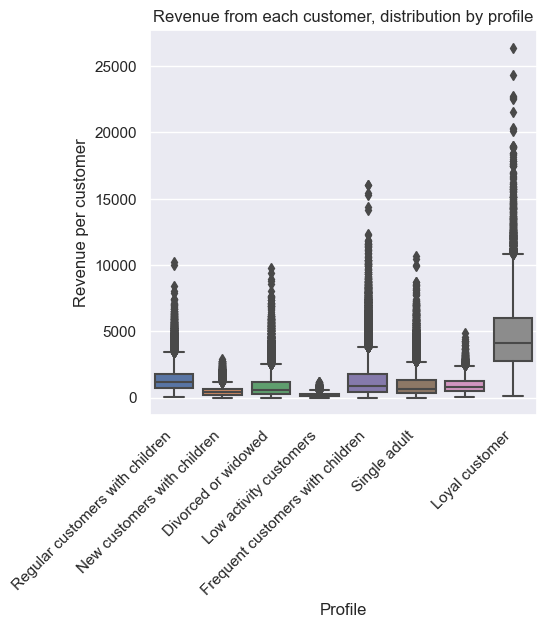

In [494]:
# Createing a box plot for the distribution of Revenue from each customer for each cluster
# High spenders was excluded because thay have a lot of outliers  
revenue_by_customer_distribution_boxplot = sns.boxplot(x='profile', y='prices', 
            data=revenue_by_user[
                ~revenue_by_user['profile'].isin(['Young high spender', 'Mature high spender'])
            ])
plt.title('Revenue from each customer, distribution by profile')
plt.xlabel('Profile')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Revenue per customer')
plt.show()

In [495]:
revenue_by_customer_distribution_boxplot.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'revenue_by_customer_distribution_boxplot.png'))

Text(0, 0.5, 'Revenue')

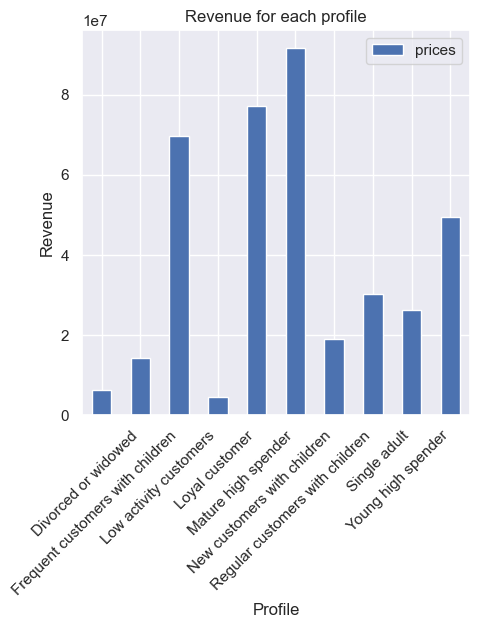

In [497]:
# Aggregating revenue from customers 
revenue_by_profile = revenue_by_user.groupby('profile').agg({'prices': 'sum'})
revenue_by_profile_bar = revenue_by_profile.plot.bar()
plt.title('Revenue for each profile')
plt.xlabel('Profile')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Revenue')

In [498]:
revenue_by_profile_bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'revenue_by_profile_bar.png'))

Text(0, 0.5, 'Revenue')

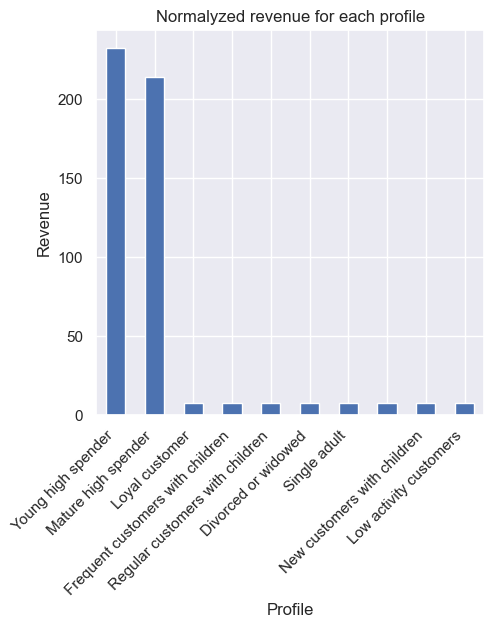

In [499]:
# Normalyzing revenue from each profile for the number of clients in each profile
normalyzed_revenue_by_profile = revenue_by_profile['prices'] / profile_customers_count
normalyzed_revenue_by_profile_bar = normalyzed_revenue_by_profile.sort_values(ascending=False).plot.bar()
plt.title('Normalyzed revenue for each profile')
plt.xlabel('Profile')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Revenue')

In [503]:
normalyzed_revenue_by_profile_bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'normalyzed_revenue_by_profile_bar.png'))

### 2. Expenditure: Max, mean, and min variables on a customer-profile level for expenditure (Q7) <a class="anchor" id="expenditure"></a>

In [519]:
# Aggregating max, mean, and min variables on a customer-profile level for expenditure.
expenditure_variables_by_user = ords_prods_merge.groupby('profile').agg({'prices': ['max','mean', 'min']})
expenditure_variables_by_user 

prices                 
                                      max        mean  min
profile                                                   
                                     25.0    7.761645  1.0
Divorced or widowed                  25.0    7.795544  1.0
Frequent customers with children     25.0    7.796437  1.0
Low activity customers               25.0    7.741025  1.0
Loyal customer                       25.0    7.768136  1.0
Mature high spender               99999.0  216.322168  1.0
New customers with children          25.0    7.773278  1.0
Regular customers with children      25.0    7.789795  1.0
Single adult                         25.0    7.774211  1.0
Young high spender                99999.0  234.403094  1.0

### 3. Usage frequency: Max, mean, and min variables on a customer-profile level for Usage frequency (Q7) <a class="anchor" id="usage-frequency"></a>

In [521]:
# Creating 'median_prior_orders' column using transform()
# ords_prods_merge['median_prior_orders'] = ords_prods_merge.groupby(['user_id'])['days_since_prior_order'].transform(np.median)

# Aggregating max, mean, and min variables on a customer-profile level for usage frequency.
usage_frequency_variables_by_user = ords_prods_merge.groupby('profile').agg({'median_prior_orders': ['max','mean', 'min']})
usage_frequency_variables_by_user 

median_prior_orders                 
                                                 max       mean   min
profile                                                              
                                                30.0  24.892235  20.5
Divorced or widowed                             30.0  12.900708   0.0
Frequent customers with children                30.0   7.885971   0.0
Low activity customers                          30.0  20.267419   0.0
Loyal customer                                  14.0   5.236305   0.0
Mature high spender                             30.0  10.094051   0.0
New customers with children                     30.0  22.678746  10.5
Regular customers with children                 20.0  14.123056  10.5
Single adult                                    30.0  12.778300   0.0
Young high spender                              30.0  10.267678   0.0

### 4. Comparing customer profiles regions (Q8) <a class="anchor" id="comparing-profiles"></a>

In [377]:
# Normalized crosstab profiles across regions
crosstab_profiles_regions_normalyzed = pd.crosstab ( ords_prods_merge['profile'], ords_prods_merge['region'], dropna = False, normalize = 'index')
crosstab_profiles_regions_normalyzed

region,Midwest,Northeast,South,West
profile,,,,
,0.241363,0.168833,0.345181,0.244623
Divorced or widowed,0.230951,0.177391,0.337949,0.253709
Frequent customers with children,0.234445,0.174392,0.337145,0.254018
Low activity customers,0.235487,0.181141,0.330896,0.252476
Loyal customer,0.230535,0.178381,0.330777,0.260307
Mature high spender,0.255781,0.167667,0.316525,0.260028
New customers with children,0.234149,0.176197,0.331253,0.258402
Regular customers with children,0.239996,0.178615,0.328121,0.253268
Single adult,0.237629,0.177077,0.330993,0.254300


Text(0, 0.5, 'Destribution in %')

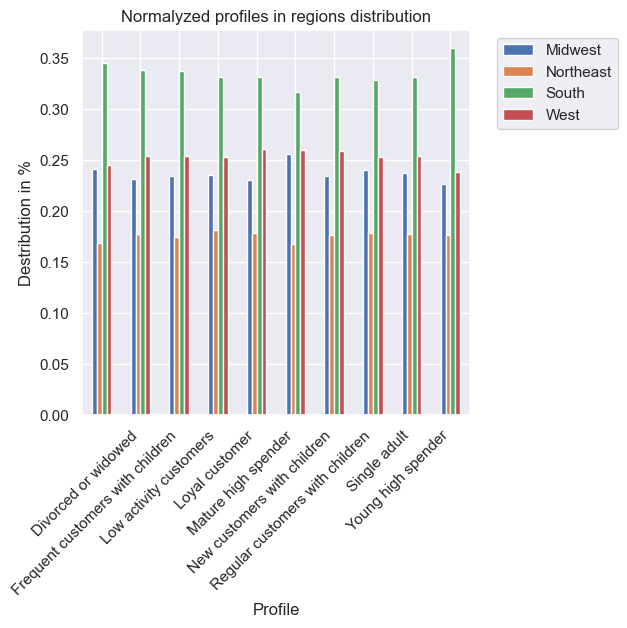

In [501]:
# Ploting the bar chart of normalyzed profiles in regions distribution Crosstab
line_plot_crosstab_profiles_regions_normalyzed = crosstab_profiles_regions_normalyzed.plot(kind = 'bar')
line_plot_crosstab_profiles_regions_normalyzed.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Normalyzed profiles in regions distribution')
plt.xlabel('Profile')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Destribution in %')


In [502]:
line_plot_crosstab_profiles_regions_normalyzed.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_plot_crosstab_profiles_regions_normalyzed.png'))

### 5. Comparing customer profiles popular product's departments. (Q8) <a class="anchor" id="comparing-departments"></a>

In [4]:
# Importing departments_wrangled.csv to add departments names
dept_df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'),index_col = False)

NameError: name 'path' is not defined

In [397]:
# Renaming unnamed column to Department Id for more clarity
dept_df.rename(columns = {"Unnamed: 0": "department_id"}, inplace= True)

# Adding department names to the main df ords_prods_merge
departments_names_map = dict(zip(dept_df["department_id"], dept_df["department"]))
ords_prods_merge['department_name'] = ords_prods_merge['department_id'].map(departments_names_map)

In [1]:
departments_names_map.values()

NameError: name 'departments_names_map' is not defined

In [411]:
# Creating datarfame with count in sold products in each department with each profile 
product_departments_by_profile_count = pd.DataFrame(ords_prods_merge.groupby('profile', as_index=False)['department_name'].value_counts(dropna = False))


In [510]:
# Groupin the dataframe by profile and department_name
grouped = product_departments_by_profile_count.groupby(['profile'])

# Calculating the sum of counts for each group
summed = grouped['count'].transform('sum')

# Dividing each count by the sum for its group
product_departments_by_profile_count['normalised_count'] = product_departments_by_profile_count['count'] / summed

In [508]:
# Creating department list with sort for plots 
departments_order = product_departments_by_profile_count.groupby(['department_name'], as_index=False).sum('count').sort_values('count', ascending = False)['department_name']
departments_order.values

array(['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry',
       'bakery', 'canned goods', 'deli', 'dry goods pasta', 'household',
       'meat seafood', 'breakfast', 'personal care', 'babies',
       'international', 'alcohol', 'pets', 'missing', 'other', 'bulk'],
      dtype=object)

#### Grid of barplots with NORMALYZED popularity of products from different depurtments among customers profiles

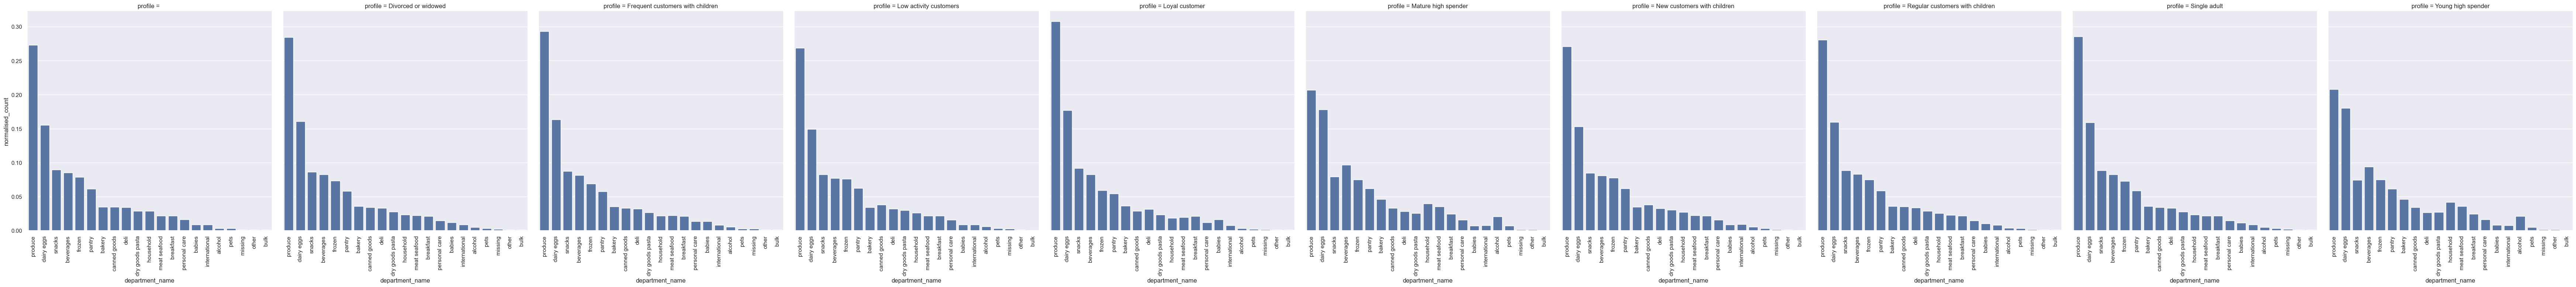

In [511]:
departments_popularity_normalyzed = sns.FacetGrid(product_departments_by_profile_count, col="profile", height=7)
departments_popularity_normalyzed.map(
    sns.barplot, 
    "department_name", 
    "normalised_count", 
    order = departments_order.values
)
departments_popularity_normalyzed.set_xticklabels(rotation = 90)

In [512]:
departments_popularity_normalyzed.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'departments_popularity_normalyzed.png'))

#### Grid of barplots with ABSOLUTE NUMBERS of popularity of products from different depurtments among customers profiles

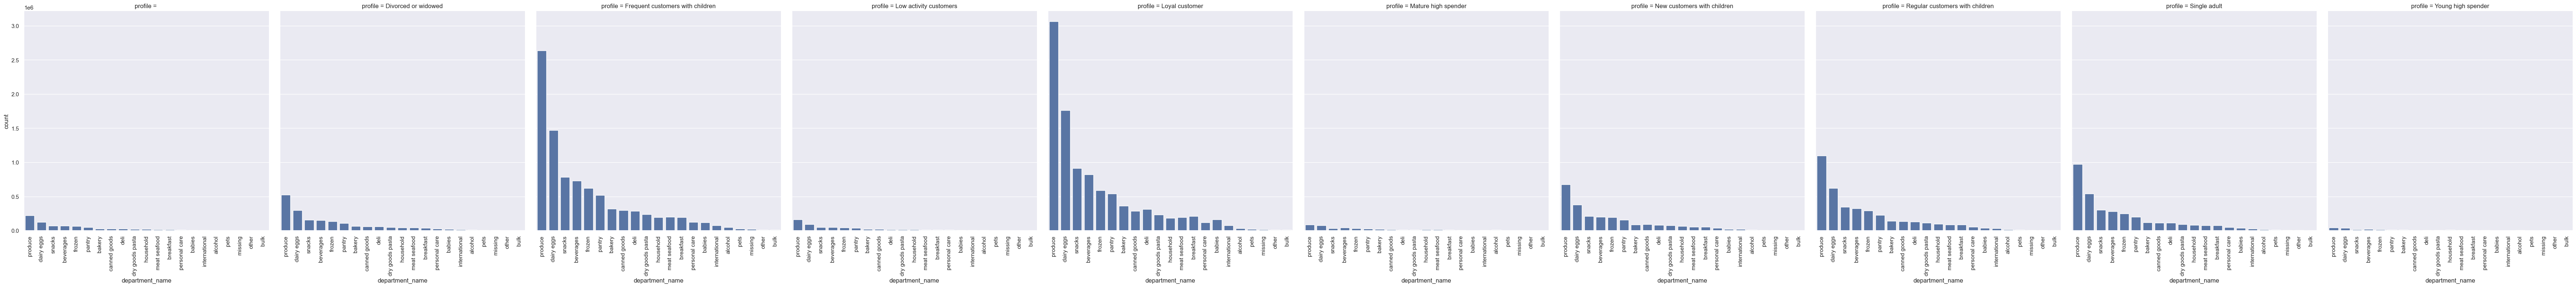

In [513]:
departments_popularity = sns.FacetGrid(product_departments_by_profile_count, col="profile", height=7)
departments_popularity.map(
    sns.barplot, 
    'department_name', 
    'count', 
    order = departments_order.values
)
departments_popularity.set_xticklabels(rotation = 90)

In [514]:
departments_popularity.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'departments_popularity.png'))